In [1]:
# Setup (Imports)

from LoadData import *

from keras.models import Sequential
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import Dense, LSTM, Dropout, Flatten, Conv1D, BatchNormalization, Activation

import numpy as np

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# Setup (Globals/Hyperz)

window_size = 30
epochs      = 2000
batch_size  = 128
emb_size    = 5

In [3]:
# Loading and Splitting Data

def get_data(stock, output='up/down'):
    
    AllX, AllY = create_timeframed_alldata_classification_data(stock, window_size, norm=True, output=output)
    
    trainX, trainY, testX, testY = split_data(AllX, AllY, ratio=.85)
    
    return (trainX, trainY), (testX, testY)


In [4]:
# Setup (Create Model)

def get_model():
    
    model = Sequential()
    
    model.add(Conv1D(input_shape=(window_size, emb_size),
                     filters=32,
                     kernel_size=4,
                     padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.5))

    model.add(Conv1D(filters=16,
                     kernel_size=4,
                     padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.5))
 
    model.add(Flatten())
    
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.5))

    model.add(Dense(2, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        
    return model


In [5]:
# Run (Load)

if __name__ == "__main__":

    (trainX, trainY), (testX, testY) = get_data('AAPL')

    print(trainX.shape, trainY.shape)


(3759, 30, 5) (3759, 2)


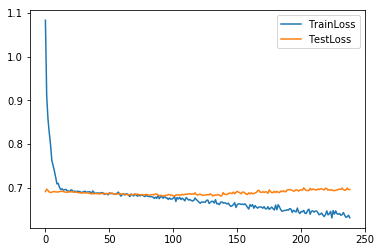

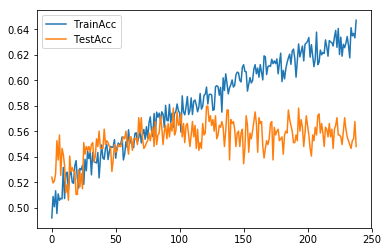

In [6]:
# Run (Train)

if __name__ == "__main__":

    model = get_model()

    reduce_LR = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=30, min_lr=0.000001, verbose=0)
    e_stopping = EarlyStopping(patience=100)

    history = model.fit(trainX, trainY, epochs=epochs, 
                                        batch_size=batch_size, 
                                        validation_data=(testX, testY), 
                                        verbose=0, 
                                        callbacks=[reduce_LR, e_stopping])

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['TrainLoss', 'TestLoss'])
    plt.show()

    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.legend(['TrainAcc', 'TestAcc'])
    plt.show()
    
    model.save(os.path.join('models', 'basic-classification.h5'))
